In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA, DrawRecNet

# Save figures?
SaveFigs=True

device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)



####### Set parameter values

# Number of neurons in recurrent net
N = 200

# Parameters for connectivity matrix
c=-10
rho=0.5


# Time step size, timescale of dynamics
dt = 0.01
tau = 1


###### Generate variables 

# Direction, u, of low rank part
u = torch.randn(N).to(device)
u *= 1/u.norm()

# Create v as a random unit vector orthogonal to u using Gram-Schmidt
v = torch.randn(N).to(device)
# Project v_temp onto u and subtract to get orthogonal component
v = v - torch.dot(v, u) * u
# Normalize to make it a unit vector
v *= 1/v.norm()

print(u@v)

# v = torch.randn(N).to(device)
# v *= 1/v.norm()

# Connectivity
W0 = c*torch.outer(u,v)
W1 = rho*torch.randn(N,N).to(device)/np.sqrt(N)
W = W0 + W1

# Random direction
urand = torch.randn(N).to(device)
urand *= 1/urand.norm()

# Coefficient for RNN Euler integrator
eta = dt/tau

# Model and random model
model = RateModel(W, f='id', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)

# singular values and eigenvalues of connectivity
with torch.no_grad():
    sigmaW = torch.linalg.svdvals(W.cpu())
    lamW = torch.linalg.eigvals(W.cpu())
    print('max real e-val of W:',torch.real(lamW).max().item())
    print('min real e-val of W:',torch.real(lamW).min().item())


####### First simulation (panel d)

# Strength of stimuli
cx=1

# Duration of stimuli in time
tstim = 25

# Duration of breaks between stimuli
tbreak = 15

# Times at which the two stimuli turn on and off
t1on = tbreak
t1off = t1on+tstim
t2on = t1off+tbreak
t2off = t2on+tstim

# Duration of sim
T = t2off+tbreak+5
time=np.arange(0,T,dt)
Nt=len(time)

u_opt = u + (W1@v-v)/c
u_opt *= 1/u_opt.norm()

# Build input
x = torch.zeros(1, Nt, N).to(device)
x[0,int(t1on/dt):int(t1off/dt),:] = cx*u_opt
x[0,int(t2on/dt):int(t2off/dt),:] = cx*urand

# Run simulation
t0=tm()
with torch.no_grad():
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=(.1/np.sqrt(N))*torch.randn(N).to(device) )
    z = model.hidden_state_history
    tSim1=tm()-t0
    print('Time for first sim:',tSim1,'s')

# Print ratio between first and secon response
ratio1 = (z[0,int(t2off/dt)-2,:].norm()/z[0,int(t1off/dt)-2,:].norm()).item()
print('Ratio between response to rand vs aligned inputs:',ratio1)

print('Angle between response to u_opt and v:', torch.acos(z[0,int(t1off/dt)-2,:]@v/z[0,int(t1off/dt)-2,:].norm()).item()*180/np.pi)

####### Second simulations (panels e-h and Supp Fig?)

# Duration of sim
T2=5000

# Timescale and strength of Guassian random stimulus
taux=10
sigmax=1

# Discretized time for second sim
time2=np.arange(0,T2,dt)
Nt2=len(time2)


# Generate input and run sim
with torch.no_grad():
    t0=tm()
    x2 = sigmax*MakeSmoothGaussianProcess(taux,Nt2,dt,N,device=device).T
    x2 = x2[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')
    t0=tm()
    r2 = model(x2, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z2 = model.hidden_state_history

    # r3 = rand_model(x2, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    # z3 = rand_model.hidden_state_history
    
    tsim2 = tm()-t0
    print('Time for second sim:',tsim2,'s')

# Perform PCA on x and z
t0=tm()
Ux,Sx=TorchPCA(x2[0,:,:], scaled=False)
Uz,Sz=TorchPCA(z2[0,:,:], scaled=False)
print('Time for PCA calc:',tm()-t0)


# Get input variable
y2=model.recurrent_layer(r2)




Device = cpu
tensor(1.4901e-08)
max real e-val of W: 0.6157549023628235
min real e-val of W: -0.5115081667900085
Time for first sim: 0.2605869770050049 s
Ratio between response to rand vs aligned inputs: 13.813826560974121
Angle between response to u_opt and v: 0.01978234059262607
Time to generate x(t): 1.5859718322753906 s
Time for second sim: 12.818274021148682 s
Time for PCA calc: 4.094299077987671


In [2]:

# Define projected variables
xu = x2[0,:,:]@u
xurand = x2[0,:,:]@urand
zu = z2[0,:,:]@u
zurand = z2[0,:,:]@urand
yu = y2[0,:,:]@u
ru = r2[0,:,:]@u

# Define projected variables
xv = x2[0,:,:]@v
zv = z2[0,:,:]@v
yv = y2[0,:,:]@v
rv = r2[0,:,:]@v

xuN = x2[0,:,:]@Uz[:,-1]
zuN = z2[0,:,:]@Uz[:,-1]
yuN = y2[0,:,:]@Uz[:,-1]
ruN = r2[0,:,:]@Uz[:,-1]


xycorr = torch.corrcoef(torch.stack((xu,yu)))[0,1].item()
print('corr coef between xu and yu=Wru:',xycorr)


uuangle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz[:,-1],u.cpu(),dim=0)).item()
print('Angle btwn smallest sing vec and u:',uuangle,'degrees')

ratio2=(zu.var()/zurand.var()).item()
print('Ratio between var in direction u vs urand:',ratio2)

ratio2=(zurand.var()/zuN.var()).item()
print('Ratio between var in direction urand vs uN:',ratio2)




corr coef between xu and yu=Wru: 0.023726200684905052
Angle btwn smallest sing vec and u: 96.74077766806629 degrees
Ratio between var in direction u vs urand: 99.91463470458984
Ratio between var in direction urand vs uN: 189.87969970703125


done


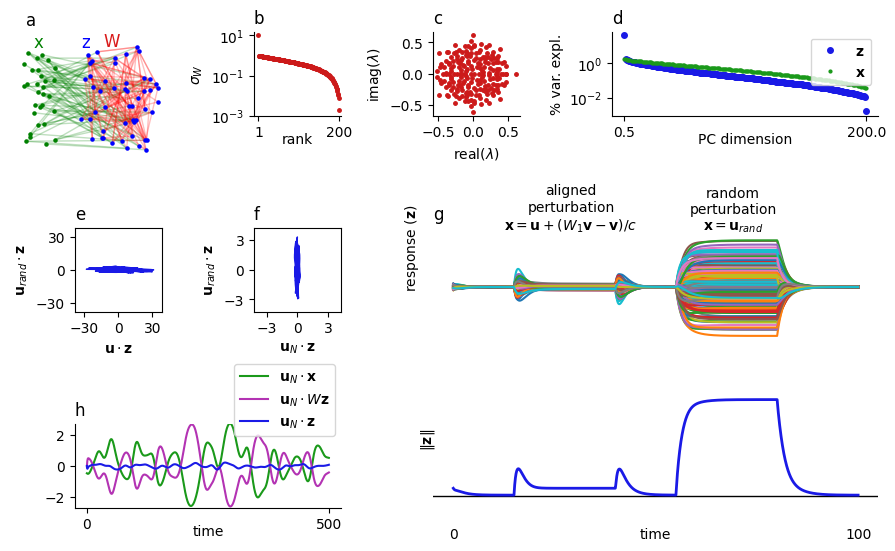

In [3]:

### Make Figure
plt.rcParams["pdf.fonttype"]="truetype"
plt.rcParams["svg.fonttype"]="none"

xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N


fig, axes = plt.subplot_mosaic("abcdd;efggg;hhggg",figsize=(9,5.65))



c0='a'
ax0 = axes[c0]
DrawRecNet(ax0)
# im = plt.imread('./NetSchematic.png')
# ax0.imshow(im, aspect=1)
# ax0.axis('off')
# #ax0.text(.25,.4,'network\nschematic\nhere',color=(.5,.5,.5))
ax0.set_title(c0,loc='left',x=0.1,y=1.025)

c0='b'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,ToNP(sigmaW),'.',markersize=5, color=Wclr)
ax0.set_yscale('log')
ax0.set_yticks([.001,0.1,10])
ax0.set_xlim([-10,N+5])
#ax0.set_yticks([0,.5,1])
ax0.set_xticks([1,N])
ax0.set_xlabel('rank',labelpad=-5)
ax0.set_ylabel(r'$\sigma_W$')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)

c0='c'
ax0 = axes[c0]
ax0.plot(ToNP(torch.real(lamW)),ToNP(torch.imag(lamW)),'.',markersize=5, color=Wclr)
#ax0.set_xlim(left=-11)
ax0.set_xlabel(r'real($\lambda$)')
ax0.set_ylabel(r'imag($\lambda$)')
ax0.set_yticks([-.5,0,.5])
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)

c0='d'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,100*Sz/Sz.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
#ax0.plot(np.arange(N)+1,100*SCzlin/SCzlin.sum(),'.',label=r'$\mathbf{z}\;(W=W_1)$',markersize=2,color='r')
ax0.set_xscale('linear')
ax0.set_yscale('log')
ax0.set_xlabel('PC dimension',labelpad=-5)
ax0.set_xticks([0.5,N])
ax0.set_ylim(bottom=(100*Sz/Sz.sum()).min()*.5)
ax0.set_ylabel('% var. expl.')
ax0.legend(loc='best')#(.98,.05))
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


c0='e'
ax0 = axes[c0]
xumax=torch.max(torch.cat((torch.abs(xu),torch.abs(xurand)))).item()
zumax=torch.max(torch.cat((torch.abs(zu),torch.abs(zurand)))).item()
xzumax=max(xumax,zumax)

I2plot=int(2000/dt)
numplot=N
ax0.plot(ToNP(zu[:I2plot]),ToNP(zurand[:I2plot]),color=zclr,lw=1)
ax0.axis([-xzumax,xzumax,-xzumax,xzumax])
ax0.set_xticks([-30,0,30])
ax0.set_yticks([-30,0,30])
#ax0.set_xticklabels([])
#ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{z}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{z}$')
ax0.set_title(c0,loc='left')

c0='f'
ax0 = axes[c0]
xvmax=torch.max(torch.cat((torch.abs(xuN),torch.abs(xurand)))).item()
zvmax=torch.max(torch.cat((torch.abs(zuN),torch.abs(zurand)))).item()
xzvmax=max(xvmax,zvmax)

I2plot=int(2000/dt)
numplot=N
ax0.plot(ToNP(zuN[:I2plot]),ToNP(zurand[:I2plot]),color=zclr,lw=1)
ax0.axis([-xzvmax,xzvmax,-xzvmax,xzvmax])
ax0.set_xticks([-3,0,3])
ax0.set_yticks([-3,0,3])
#ax0.set_xticklabels([])
#ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}_N\cdot\mathbf{z}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{z}$')
ax0.set_title(c0,loc='left')


c0='g'
ax0 = axes[c0]
numplots = 2
plotstep = 1/numplots
gap = .2
def normalize(x):
    return (x-x.min())/(x.max()-x.min())
ax0.plot(time,plotstep*(1-2*gap)*ToNP(normalize(z[0,:,:numplot]))+(1+gap)*plotstep)
ax0.axis('off')
xmin, xmax = ax0.get_xaxis().get_view_interval()
ymin, ymax = ax0.get_yaxis().get_view_interval()
ax0.add_artist(plt.Line2D((xmin, xmax), (gap*plotstep*.98, gap*plotstep*.98), color='black', linewidth=1))
ax0.plot(time,plotstep*(1-2*gap)*ToNP(normalize(z[0,:,:].norm(dim=1)))+(0+gap)*plotstep, color=zclr, lw=2)
#ax0.set_yticks([])
#ax0.set_xticks([0,T])
#ax0.set_xlabel('time')u+(W1@v-v)/c
#ax0.text((t1on+t1off)/2,1,r'  $\mathbf{x}=\mathbf{x}_{aligned}$',horizontalalignment='center',verticalalignment='bottom')
ax0.text((t1on+t1off+tstim/8)/2,.92,'aligned\nperturbation\n'+r'$\mathbf{x}=\mathbf{u}+(W_1\mathbf{v}-\mathbf{v})/c$',horizontalalignment='center',verticalalignment='bottom')
ax0.text((t2on+t2off+tstim/8)/2,.92,'random\nperturbation\n'+r'$\mathbf{x}=\mathbf{u}_{rand}$',horizontalalignment='center',verticalalignment='bottom')
#ax0.text((t2on+t2off)/2,1,r'  $\mathbf{x}=\mathbf{x}_{rand}$',horizontalalignment='center',verticalalignment='bottom')
#ax0.text((t3on+t3off)/2,1,r'$x_{mixed}$',horizontalalignment='center',verticalalignment='bottom')
ax0.text(0,1.5/2,r'response ($\mathbf{z}$)'+'\n\n',rotation='vertical',horizontalalignment='right')
ax0.text(0,0.5/2,r'$\|\mathbf{z}\|$'+'\n',rotation='vertical',horizontalalignment='right')
ax0.text(T/2,0,'time',va='top',ha='center')
ax0.text(0,0,'0',va='top',ha='center')
ax0.text(T,0,str(int(T)),va='top',ha='center')
#ax0.text(T,(0+gap)*plotstep,'0',va='baseline')
ax0.set_title(c0,loc='left')



c0='h'
ax0 = axes[c0]
I1plot=int(.2/dt)
I2plot=int(500/dt)
xuNmax=torch.max(torch.abs(xuN[:I2plot])).item() 
zuNmax=torch.max(torch.abs(zuN[:I2plot])).item()
xzuNmax=max(xuNmax,zuNmax)
ax0.plot(time2[I1plot:I2plot],ToNP(xuN[I1plot:I2plot]),label=r'$\mathbf{u}_N\cdot\mathbf{x}$', color=xclr)
ax0.plot(time2[I1plot:I2plot],ToNP(yuN[I1plot:I2plot]),label=r'$\mathbf{u}_N\cdot W\mathbf{z}$', color=yclr)
ax0.plot(time2[I1plot:I2plot],ToNP(zuN[I1plot:I2plot]),label=r'$\mathbf{u}_N\cdot\mathbf{z}$', color=zclr)
ax0.set_xticks([0,int(I2plot*dt)])
#ax0.set_yticks([-30,0,30])
ax0.set_ylim([-xzuNmax,xzuNmax])
#ax0.text(-2,0,'time')
ax0.set_xlabel('time',labelpad=-5)
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)
ax0.legend(loc=(.6,.85))



fig.tight_layout()


# Turn off automatic axis scaling for networkx panel
axes['a'].autoscale(False)
# Manual positioning
axes['a'].set_position([.01, 0.7, 0.18, 0.22]) 

if SaveFigs:
    fig.savefig('./Figures/Figure2.pdf')
    fig.savefig('./Figures/Figure2unpolished.svg')


print('done')
